# DH-401: Digital Musicology semester project
---------------
## Predicting music popularity using DNNs - Milestone 2
-------------------

# Dataset

We decided to use [FMA: A Dataset for Music Analysis](https://arxiv.org/abs/1612.01840) for our project. The dataset is publicly available on [Github](https://github.com/mdeff/fma) and the files are stored on UNIL/SWITCH server.

## General overview

The FMA dataset consists of "917 GiB and 343 days of Creative Commons-licensed audio from 106,574 tracks from 16,341 artists and 14,854 albums, arranged in a hierarchical taxonomy of 161 genres. It provides full-length and high-quality audio, pre-computed features, together with track- and user-level metadata, tags, and free-form text such as biographies." *(Defferrard, M., Benzi, K., Vandergheynst, P., & Bresson, X. (2017). FMA: A Dataset for Music Analysis. ArXiv, abs/1612.01840.)*. 

To the best of our knowledge, it is the biggest, publicly available dataset of music, which consist of both raw music files (MP3) and metadata, and which can be analysed legally (on Creative Commons license)

This fact makes it good and easy source for music analysis, however this easiness comes at price. Considering our analysis is scoped on popularity of music, we might expect the top popularity music not to be part of this dataset. The music business is very vivid and profitable, and therefore publishing work on Creative Commons license is an uncommon practice, generally applicable to low popularity bands.

On the other hand, the fact of using only the Creative Commons music and skipping the top music hits, can make our project less prone to biases - since the promotion of the pop musicians is the large scale, nuanced, sociotechnical project, their popularity might reflect the actual musical piece content only to some very small extent. People tend to listen to pop song, because they hear it everywhere around. But when they listen to the niche music, they must have better reasons. We will try to find, and describe the mechanism behind this popularity.

We accept the fact that our dataset is only a small sample of the whole music world, and cannot represent the global trends well. Probably, given the amount of music recordings in the human history, the complete dataset won't ever exist. Presumably only the streaming platforms such as spotify might have the music library which is nearly complete.


## Raw music files

There are three different shapes of the raw music dataset one can download. 

* fma_small: 8,000 tracks of 30s, 8 balanced genres (7.2 GiB)  
This small subset is very useful, since it provides us with only 8, well balanced genres of the music. This will allow us to perform follow up, per-genre popularity analysis of the music. Since we assume that in full, cross-genre analysis, we might see the very general popularity trends, but lose the nuanced rules, that we can find when we analyse only the music of the same type. Also, these tracks were trimed to 30 seconds and were selected as the ones with the most complete metadata, which makes them the best option for our exploratory analysis

* fma_medium: 25,000 tracks of 30s, 16 unbalanced genres (22 GiB)  
The medium dataset consists only of the music with well-defined, top genres and the most complete metadata. Since we assumed this sample is too small for pre-training, but uses unbalanced genres, and thus it cannot be easily used for per-genre popularity analysis. Therefore, we decided not to use this size

* fma_large: 106,574 tracks of 30s, 161 unbalanced genres (93 GiB)  
This dataset contains every music piece collected by the autors, trimmed to 30 seconds. This setup makes it a perfect choice for the unsupervised pre-training, which we will perform on the raw music data chunks using wav2vec2.0

* fma_full: 106,574 untrimmed tracks, 161 unbalanced genres (879 GiB)  
full, raw data, acquired by the authors. Due to data volume, and amount of computational power required to process samples longer than 30s, we decided not to use this dataset.

The dataset is a zip archive, containing a flat structure of music files denoted by their IDs. All of the music is encoded using MP3. Most of them is using sampling rate of 44,100 Hz, bit rate 320 kbit/s (263kbit/s on average), and in recorded in stereo.

**DISCLAIMER:** The dataset authors have done very good job performing the exploratory data analysis on their own, so we don't get into much details for many basic metadata exploration topics, since that would require us to just copy their work. The original analysis is available in [usage.ipynb](https://nbviewer.jupyter.org/github/mdeff/fma/blob/outputs/usage.ipynb) and [analysis.ipynb](https://nbviewer.jupyter.org/github/mdeff/fma/blob/outputs/analysis.ipynb)

In [ ]:
from zipfile import ZipFile
from tqdm import tqdm

from IPython import display
import librosa

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np

from scipy.stats import chisquare

plt.rcParams['figure.figsize'] = (17, 5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Download fma_small
!wget https://os.unil.cloud.switch.ch/fma/fma_small.zip

--2021-04-25 08:00:30--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  27.3MB/s    in 4m 40s  

2021-04-25 08:05:11 (26.1 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]



In [ ]:
# Extract the first 50 mp3 files
with ZipFile('fma_small.zip', 'r') as zip_file:
    for file in tqdm(iterable=zip_file.namelist()[:50], total=50):
        zip_file.extract(member=file)

100%|██████████| 50/50 [00:05<00:00,  9.14it/s]


In [ ]:
# Check the parameters and play a random raw audio sample
x, sr = librosa.load("fma_small/000/000002.mp3", sr=None, mono=True)
print(f'Duration: {x.shape[-1] / sr}s, {x.size} samples, rate: {sr}')

display.Audio(data=x, rate=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.976575963718822s, 1321967 samples, rate: 44100


### Raw music files for Wav2vec 2.0, and first deep learning efforts

The training efforts, which we currently work on, require us to perform further data processing:

1. The pre-training is currently only available using the latest facebook FAIRSEQ library. The pre-training pipeline expects the 30s clips of 16k sample rate, in either WAV or FLAC format. Therefore, we used `sox` software to convert the samples to FLAC, while downsampling them from 44k to 16k. Currently, it's being tested on small sample, and the final training will be performed on the large dataset. Google Colab Tesla V100 is used for training.
2. Then, the FAIRSEQ model checkpoint is converted to Huggingface Transformers format, using the [conversion script](https://github.com/huggingface/transformers/blob/master/src/transformers/models/wav2vec2/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py).
3. The linear layer with one output is added on top of the embedding output of the raw model. This architecture will be fine-tuned for popularity prediction. The question of good popularity metric will be explored in the following parts of our analysis.

For clarity of our exploratory analysis, we keep our wav2vec notebook separately. You are welcome to see the current efforts [on our Google Colab](https://colab.research.google.com/drive/1uvoD4ewLmCBlSwzXLxnR17BQPWPg-33R?usp=sharing)

## Metadata files
Following the description from the original dataset page, metadata consists of following files:
* `tracks.csv`: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.
* `genres.csv`: all 163 genres with name and parent (used to infer the genre hierarchy and top-level genres).
* `features.csv`: common features extracted with librosa.
* `echonest.csv`: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.

We will explore this files in the following sections


In [ ]:
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

# Extract the metadata
with ZipFile('fma_metadata.zip', 'r') as zip_file:
    for file in zip_file.namelist():
        zip_file.extract(member=file)

--2021-04-25 08:06:10--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81M  27.2MB/s    in 15s     

2021-04-25 08:06:25 (23.2 MB/s) - ‘fma_metadata.zip’ saved [358412441/358412441]



### Tracks

This is the main file that contains all the contextual metadata which are normally provided to the human listener, such as artist, title, publisher and publication date. It also provides additional dataset-specific information, such as suggested train/test split when using as ML applications benchmark, and the smallest subset (small/medium/large) of the dataset, to which the sample belongs.

The format of the tracks CSV is very unusual. It contains multi-level header and consists of multiple different types of data. Fortunately, the dataset creators provided the official loader script which we use below to load the data

In [ ]:
# Load metadata and features.
# Function based on: https://github.com/mdeff/fma/blob/master/utils.py
tracks = pd.read_csv('fma_metadata/tracks.csv', index_col=0, header=[0, 1])

COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
            ('track', 'genres'), ('track', 'genres_all')]
for column in COLUMNS:
    tracks[column] = tracks[column].map(ast.literal_eval)

COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
            ('album', 'date_created'), ('album', 'date_released'),
            ('artist', 'date_created'), ('artist', 'active_year_begin'),
            ('artist', 'active_year_end')]
for column in COLUMNS:
    tracks[column] = pd.to_datetime(tracks[column])

SUBSETS = ('small', 'medium', 'large')
try:
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
            'category', categories=SUBSETS, ordered=True)
except (ValueError, TypeError):
    # the categories and ordered arguments were removed in pandas 0.25
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
              pd.CategoricalDtype(categories=SUBSETS, ordered=True))

COLUMNS = [('track', 'genre_top'), ('track', 'license'),
            ('album', 'type'), ('album', 'information'),
            ('artist', 'bio')]
for column in COLUMNS:
    tracks[column] = tracks[column].astype('category')


tracks

album  ...                                      track
         comments  ...                                      title
track_id           ...                                           
2               0  ...                                       Food
3               0  ...                               Electric Ave
5               0  ...                                 This World
10              0  ...                                    Freeway
20              0  ...                            Spiritual Level
...           ...  ...                                        ...
155316          0  ...                                  The Auger
155317          0  ...                            Let's Skin Ruby
155318          0  ...         My House Smells Like Kim Deal/Pulp
155319          0  ...                    The Man With Two Mouths
155320          0  ...  Another Trick Up My Sleeve (Instrumental)

[106574 rows x 52 columns]

### Genres
The file contains a complete genres forest structure, organized as node list.
For each genre, we got its: title, number of tracks that belong to it or to its children, the ID of the parent genre, and the ID of the highest level genre.


In [ ]:
genres = pd.read_csv('fma_metadata/genres.csv', index_col=0)
genres

#tracks  parent          title  top_level
genre_id                                           
1            8693      38    Avant-Garde         38
2            5271       0  International          2
3            1752       0          Blues          3
4            4126       0           Jazz          4
5            4106       0      Classical          5
...           ...     ...            ...        ...
1032           60     102        Turkish          2
1060           30      46          Tango          2
1156           26     130           Fado          2
1193           72     763      Christmas         38
1235        14938       0   Instrumental       1235

[163 rows x 4 columns]

In [ ]:
print(f"There is {len(genres.top_level.unique())} top-level genres, from which all the other genres inherit")

There is 16 top-level genres, from which all the other genres inherit


### Features

This file contains a complete set of fundamental signal analysis features, extracted by authors using librosa.

While these features are not easily interpretable for human being, they might be the core for understanding music popularity using statistical methods

In [ ]:
features = pd.read_csv('fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
features

feature    chroma_cens                      ...       zcr                    
statistics    kurtosis                      ...       min      skew       std
number              01        02        03  ...        01        01        01
track_id                                    ...                              
2             7.180653  5.230309  0.249321  ...  0.000000  2.089872  0.061448
3             1.888963  0.760539  0.345297  ...  0.000000  1.716724  0.069330
5             0.527563 -0.077654 -0.279610  ...  0.000000  2.193303  0.044861
10            3.702245 -0.291193  2.196742  ...  0.000000  3.542325  0.040800
20           -0.193837 -0.198527  0.201546  ...  0.000977  3.189831  0.030993
...                ...       ...       ...  ...       ...       ...       ...
155316       -0.490129  0.463834  2.321970  ...  0.003906  0.955388  0.012385
155317       -0.461559 -0.229601 -0.496632  ...  0.002441  1.283060  0.019059
155318        0.552473 -0.110498 -0.532014  ...  0.003418  0.828569  0.017904
155319       -0.176901  0.187208 -0.050664  ...  0.004883  1.818740  0.020133
155320        0.489665  1.862421  0.854461  ...  0.004395  4.687204  0.137205

[106574 rows x 518 columns]

### Echonest

The features extracted from Echonest  
Echonest was the music analysis platform (acquired by Spotify), which provided the high-level features for the music. While these features are immensely useful, because they are both human- and machine-interpretable, this set has serious flaws.  
Most importantly, the echonest features are available only for the subset of 13129 samples, which makes it usable only for fma_small analysis.  
However, what is of the same importance, is the fact that prioprietary algorithms behing the calculated audio features, make the analysis based on these features obscure and very hard to interpret itself, as explained in the paper below.

*Eriksson, M. (2016). Close reading big data: The Echo Nest and the production of (rotten) music metadata. First Monday, 21.*

In [ ]:
echonest = pd.read_csv('fma_metadata/echonest.csv', index_col=0, header=[0, 1, 2])
echonest

echonest                         ...                                         
         audio_features                         ... temporal_features                       
           acousticness danceability    energy  ...               221        222         223
track_id                                        ...                                         
2              0.416675     0.675894  0.634476  ...           3.61288  13.316690  262.929749
3              0.374408     0.528643  0.817461  ...           6.01864  16.673548  325.581085
5              0.043567     0.745566  0.701470  ...           5.86635  16.013849  356.755737
10             0.951670     0.658179  0.924525  ...           8.33319  21.317064  483.403809
134            0.452217     0.513238  0.560410  ...          11.20267  26.454180  751.147705
...                 ...          ...       ...  ...               ...        ...         ...
124857         0.007592     0.790364  0.719288  ...           1.97678   8.144532  147.040405
124862         0.041498     0.843077  0.536496  ...           0.85996   1.794739    6.321268
124863         0.000124     0.609686  0.895136  ...           2.18894   5.578341   89.180328
124864         0.327576     0.574426  0.548327  ...           1.42354   2.173092   12.503966
124911         0.993606     0.499339  0.050622  ...          16.49143  15.169022  302.946350

[13129 rows x 249 columns]

## 3. Exploratory Analysis

### Feature Exploration

#### Dates of the musics

We will analyse music from 2008 to 2018, that looks quite uniformly distributed in time.

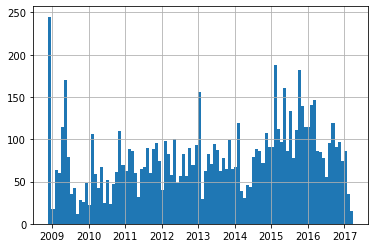

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small['track']['date_created'].hist(bins=100)

#### About the chroma in each song

The 'chroma_cens' feature corresponds to “Chroma Energy Normalized”. It is a more robust measure of the Chroma vector, which represents how much energy of each pitch class is present in the signal.

The main idea of CENS features is that taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords.

For each of the 12 pitch classes, we have data about statistics on their chroma :  max, min, mean, median, but also  skew, kurtosis, and standard deviation.

We can look at the distribution of the pitches that have on average the most energy in the signal, that would potentially be the tonic of each song.

In [ ]:
small_features = features[tracks['set', 'subset'] <= 'small']
small_features['chroma_cens']['mean'].head()

number          01        02        03  ...        10        11        12
track_id                                ...                              
2         0.474300  0.369816  0.236119  ...  0.175809  0.200713  0.319972
5         0.258420  0.303385  0.250737  ...  0.289821  0.246368  0.220939
10        0.229882  0.286978  0.240096  ...  0.243144  0.268941  0.236763
140       0.161163  0.272767  0.295905  ...  0.319938  0.198516  0.120607
141       0.150417  0.155785  0.217253  ...  0.296048  0.331963  0.218315

[5 rows x 12 columns]

[]

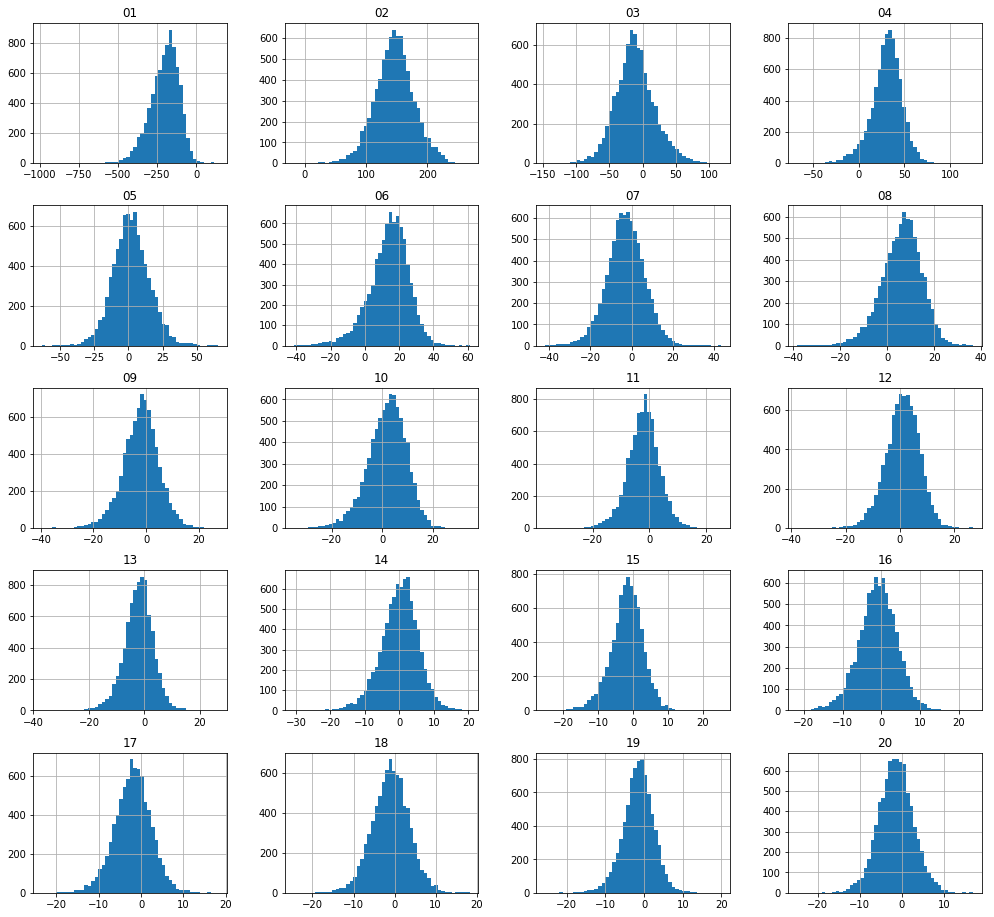

In [ ]:
small_features['mfcc']['mean'].hist(bins=50, figsize=(17, 16))
plt.plot()

All of the notes seem to follow a Gaussian distribution centered around zero, expect for the first two which are centered respectively around -150 and +150, which means that the notes are quite present in the energy of the signal. 

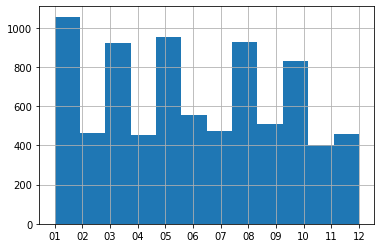

In [ ]:
small_features['chroma_cens']['mean'].idxmax(axis=1).sort_values().hist(bins=12)

Interestingly, we observe that the pitch that is on average the maximum is more frequently white keys from the piano, rather than black ones.

We also have other chroma features like 'chroma_cqt', and 'chroma_stft' that give us other insights on chroma in each songs.

#### Mel-frequency cepstral coefficients (MFCCs)

One other feature that is interesting is the MFCCs. This are the coefficients that describe the short-term power spectrum of a sound, that itself describes how power of a signal or time series is distributed over frequency.

In [ ]:
small_features['mfcc']['mean']

number            01          02         03  ...        18        19        20
track_id                                     ...                              
2        -163.772964  116.696678 -41.753826  ... -2.114676  0.116842 -5.785884
5        -205.440491  132.215073 -16.085823  ... -1.739911  0.278015 -5.489016
10       -135.864822  157.040085 -53.453247  ... -1.018324 -3.807545 -0.679533
140      -225.713318  139.332825 -13.097699  ... -2.363509 -0.158602  0.594098
141      -253.143906  155.716324 -16.636627  ...  0.768126  2.809321  3.325740
...              ...         ...        ...  ...       ...       ...       ...
154308   -288.879303  152.342087  -2.517532  ...  2.550121  5.137365  6.354999
154309   -367.696625  104.314285  11.179615  ... -5.277195 -9.561085 -8.861394
154413   -229.868378  155.606247   4.354007  ...  1.281081  4.305267  0.595658
154414   -225.491821  156.149582  -4.608137  ... -4.390033 -2.679048 -5.389973
155066   -291.700775  160.115982  93.731789  ...  2.405217  2.127824  3.123198

[8000 rows x 20 columns]

[]

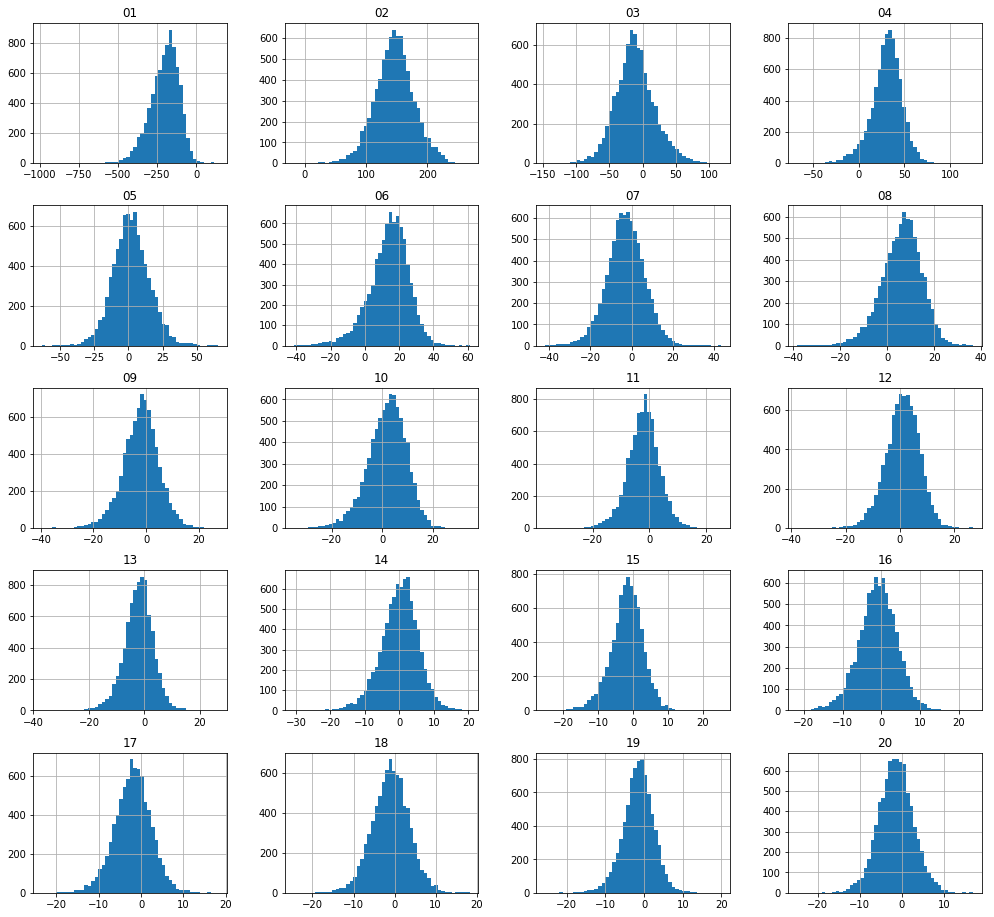

In [ ]:
small_features['mfcc']['mean'].hist(bins=50, figsize=(17, 16))
plt.plot()

Again, we observe Gaussian distributions with mean zero, except for the two first ones.

#### Root-mean-square (RMS) energy 

Corresponds to how 'loud' the music is.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70ce2c00d0>]],
      dtype=object)

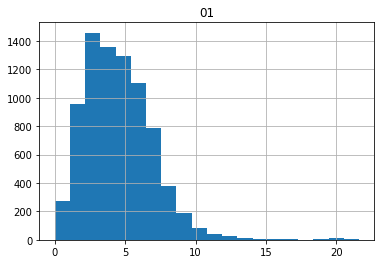

In [ ]:
small_features['rmse']['mean'].hist(bins=20)

In [ ]:
small_features['rmse']['mean'].describe()

number           01
count   8000.000000
mean       4.568130
std        2.484890
min        0.000246
25%        2.735237
50%        4.286309
75%        6.012164
max       21.608154

The RMSE in the dataset has a mean of 4.5 and a standard deviation of 2.48, ranging from almost zero to 21.6.

#### Spectral Bandwidth, centroid, contrast and rolloff

The spectral bandwidth is defined as the band width at one-half the peak maximum

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70d5f8e2d0>]],
      dtype=object)

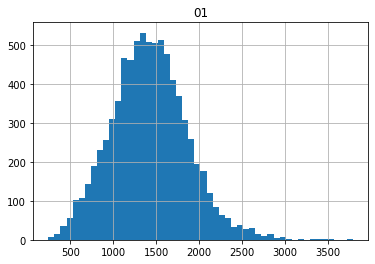

In [ ]:
small_features['spectral_bandwidth']['mean'].hist(bins=50)

In [ ]:
small_features['spectral_bandwidth']['mean'].describe()

number           01
count   8000.000000
mean    1420.529136
std      440.968569
min      241.754852
25%     1119.511719
50%     1410.169250
75%     1699.891907
max     3789.371582

It seems to again be normally distributed in the dataset, around 1420 and with a standard deviation of 440.

The centroid is an acoustical descriptor of timbre. Estimates the center of mass of the spectrum (in Hz)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70ce09d890>]],
      dtype=object)

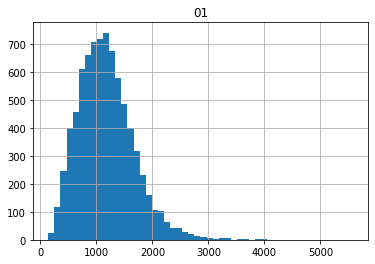

In [ ]:
small_features['spectral_centroid']['mean'].hist(bins=50)

In [ ]:
small_features['spectral_centroid']['mean'].describe()

number           01
count   8000.000000
mean    1174.792826
std      501.694070
min      140.754303
25%      818.932144
50%     1125.063171
75%     1460.376740
max     5575.107910

Then, spectral contrast different than MFCC in the following aspect : works on octaves and considers spectral peak, spectral valley and their difference in each sub-band.

[]

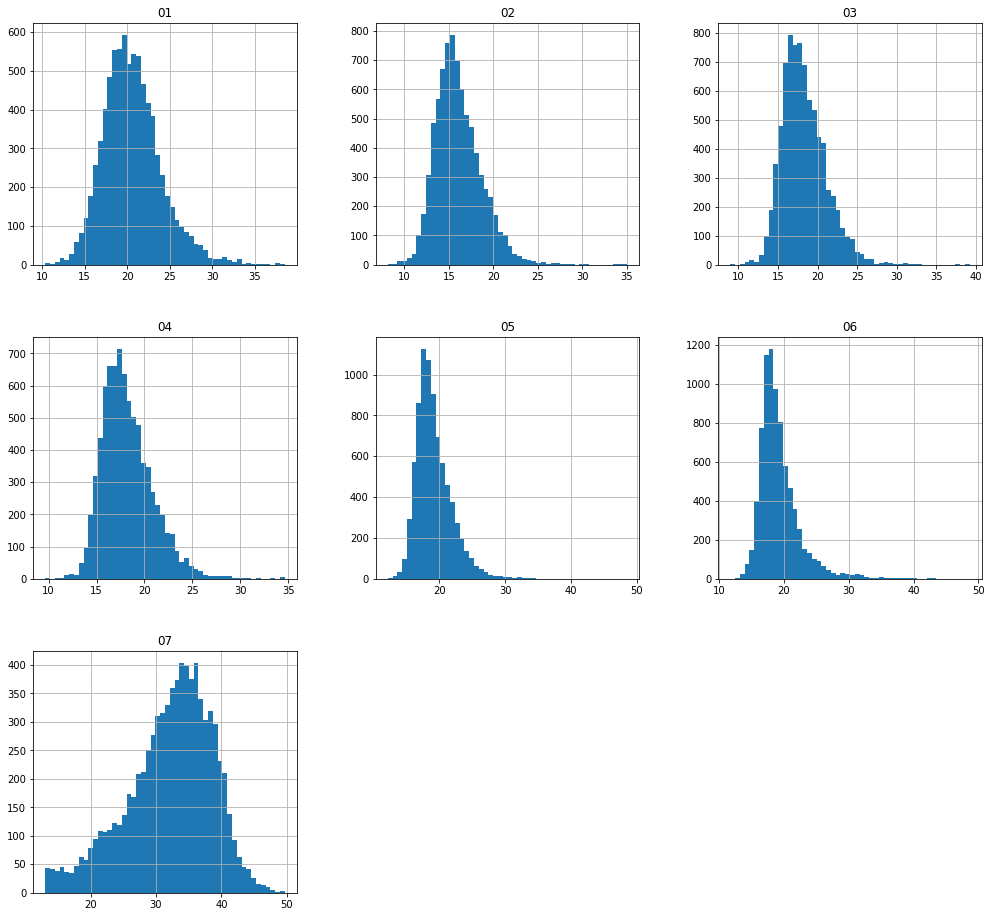

In [ ]:
small_features['spectral_contrast']['mean'].hist(bins=50, figsize=(17,16))
plt.plot()

#### Tonnetz

Finally, let's study the tonnetz features of our music tracks !

Tonnetz centroids :

0: Fifth x-axis

1: Fifth y-axis

2: Minor x-axis

3: Minor y-axis

4: Major x-axis

5: Major y-axis

In [ ]:
small_features['spectral_contrast']['mean'].head()

number           01         02         03  ...         05         06         07
track_id                                   ...                                 
2         18.005175  15.363138  17.129013  ...  18.087046  17.616112  38.268646
5         17.097452  15.969444  18.646988  ...  17.292145  19.255819  36.413609
10        19.177481  14.281867  15.510051  ...  20.316816  18.967014  34.886196
140       18.151390  16.298210  18.562231  ...  21.355371  19.176929  36.932270
141       19.646608  18.583612  19.953085  ...  22.643318  23.950989  29.015615

[5 rows x 7 columns]

[]

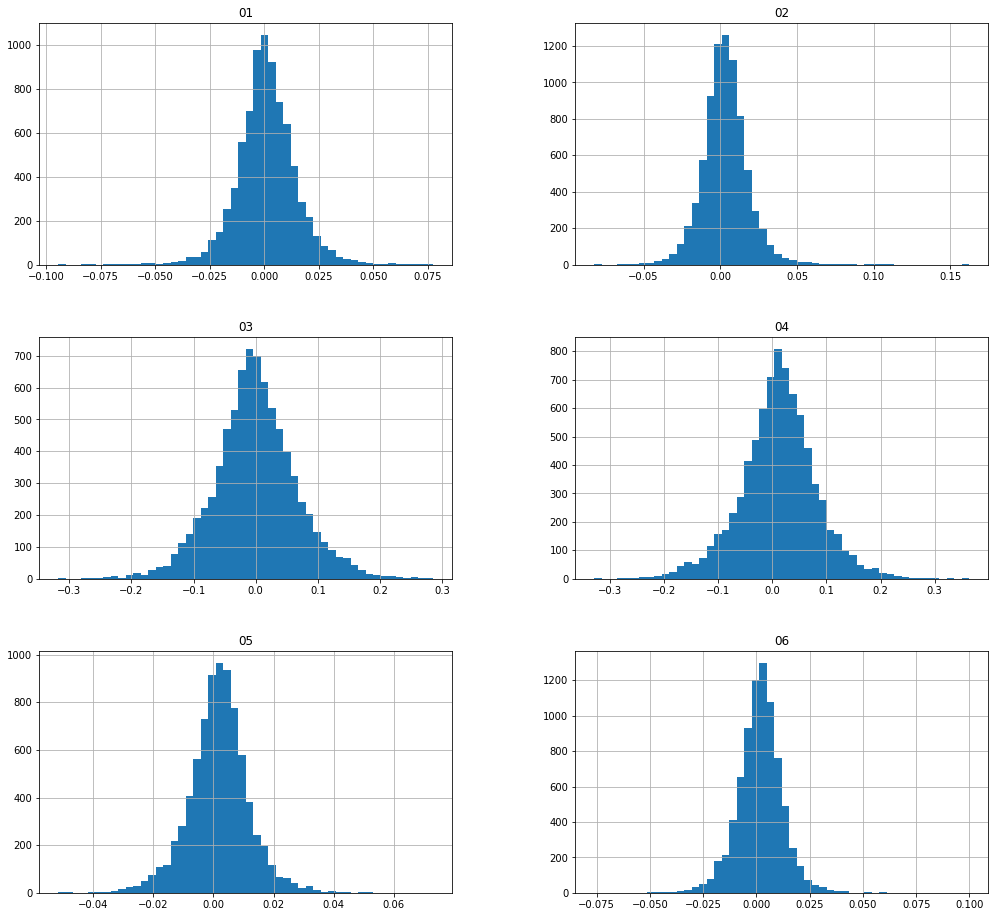

In [ ]:
small_features['tonnetz']['mean'].hist(bins=50, figsize=(17,16))
plt.plot()

The tonnetz are also following Guassian distributions.

#### Zero Crossing Rate

The rate at which a signal changes from positive to zero to negative or from negative to zero to positive.

[]

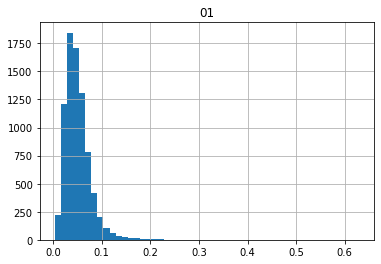

In [ ]:
small_features['zcr']['mean'].hist(bins=50)
plt.plot()

The rate is relatively small for all the music in the dataset, the extreme values beign more than 0.1

### Popularity

#### Popularity measures



The dataset contains a few measures that can be used to assess songs' popularity. The fields `favorites`, `comments`, `listens` or `interest` of the `tracks`' DataFrame could be used as such. All of them are, more or less strongly, positively correlated (see below plot) with a high significant level thanks to the large amount of data. Nonetheless we discarded `interest` as a measure of popularity as its calculation is arcane and makes it less directly interpretable. Moreover comment and favorite options on Free Music Archives' website don't seem to be largely adopted. That's why, in addition to stay closer to how music's popularity can be defined in the industry, we chose to use `listens` to characterize popularity.

On a sidenote, it could have been interesting to have access to the download's count of the songs to build a metric closer to the [units for certification purposes](https://www.riaa.com/wp-content/uploads/2016/02/DIGITAL-SINGLE-AWARD-RIAA-AND-GRF-CERTIFICATION-AUDIT-REQUIREMENTS.pdf).

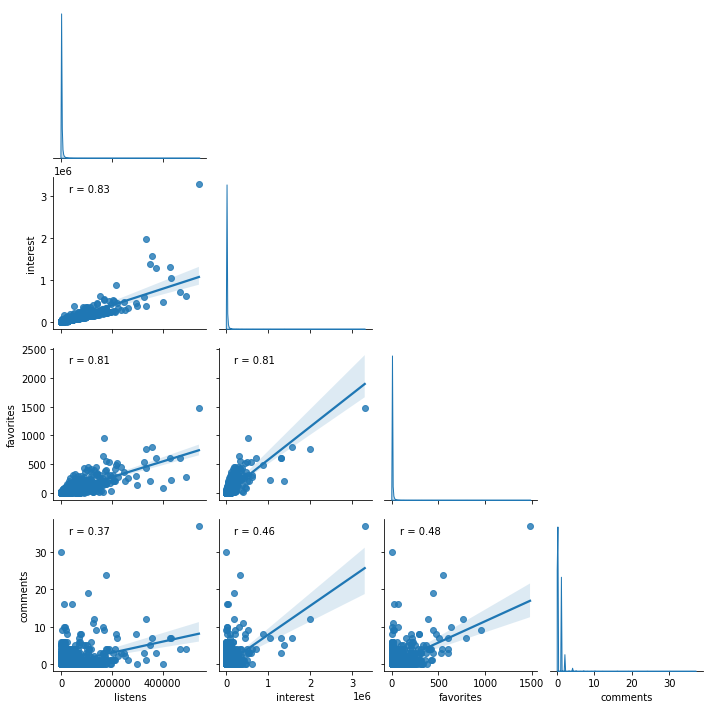

In [ ]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.pairplot(tracks["track"]
                 , vars=["listens", "interest", "favorites", "comments"]
                 , corner=True
                 , kind="reg"
                 , diag_kind="kde"
                )
g.map_lower(corrfunc)

Built upon [Free Music Archive](https://freemusicarchive.org)'s content, a strength of our dataset, being constituted of royalty-free music, can also be seen as one of its limits when it comes to our research question. Indeed, solely based on the number of listens from our dataset, songs are far from what the industry could consider as *Hit Songs*. American audio-engineer and author Bobby Owsinski wrote for [Forbes](https://www.forbes.com/sites/bobbyowsinski/2017/07/04/streams-hit-song/?sh=1dc9d110711e) in 2017 that "a song with a million streams doesn't really get you on the industry's radar", adding that "very minor hit now comes in at around 50 million [streams]". As we can see on the plots (coarsely on the bottom line of last figure and more precisely on the CCDF plotted below), none of the song present in the fma dataset go close to those numbers, the [most popular one](https://freemusicarchive.org/music/Broke_For_Free/Directionless_EP/Broke_For_Free_-_Directionless_EP_-_01_Night_Owl) recording a bit less than 550K streams at that time. Thus, it is important to acknowledge that our analysis strongly depends on the source of our data and could hardly be generalized.

On the other hand, it can also be assumpted that the external feautres, such as commercial and communicational components, might have less influence on the streams on this platform, making it more prone to emphasize popular musical features.

Let's now dig a bit on the streams' count for the songs in the dataset by plotting its distribution:

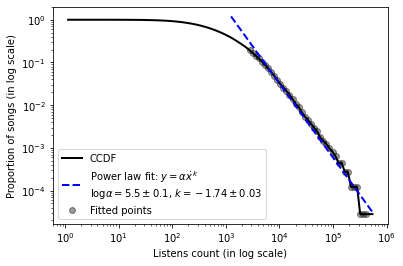

In [ ]:
from scipy.optimize import curve_fit # import to ease the implementation of the fitting function

def linlaw(x, a, b) :
    return a+x*b

def powerlaw_fit(xdata, ydata) :
    """
    Role : fit the given data (x and y) to a powerlaw : find the optimal a and b parameters in y = a*x^k
            to do so the equation is linearized: log(y)=k*log(x)+log(a)
            so that we can realise a linear fit
    
    # PARAMETERS
    xdata : array of the x-coordinates of the data to be fitted
    ydata : array of the y-coordinates of the data to be fitted
    
    # RETURN
    popt_log : array [optimal log(a), optimal k]
    perr : array one standard deviation errors on the parameters
    """
    # take the log of the arguments to linearise the equation
    xdata_log = np.log10(xdata)
    ydata_log = np.log10(ydata)
    
    # Fit linear using curve_fit and the affine function linlaw
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    # compute one standard deviation errors on the parameters
    perr = np.sqrt(np.diag(pcov_log))
    
    return (popt_log, perr)

listens = tracks["track"]["listens"]
MIN = listens.min()
MAX = listens.max()

# build the histogram as a CCDF
y, x = np.histogram(listens, bins = 10 ** np.linspace(np.log10(MIN+1), np.log10(MAX), 101))
y = (y.cumsum()[::-1])/len(listens)

# preprocessed isolation of the points where the amount of point is sufficiently linear to perform fit
n_end_fit = 2
n_start_fit = 59

# find the optimal parameters and error on the fit of our data
popt, perr = powerlaw_fit(x[n_start_fit+1:-n_end_fit], y[n_start_fit:-n_end_fit])

# isolate the parameters and errors
log_a_err = perr[0]
k_err = perr[1]

log_a_fit = popt[0]
k_fit = popt[1]

# Represent this fit on a plot with the data to visualise its pertinence
fig = plt.figure()

plt.loglog(x[1:],y
          , c='k', lw=2
           , label = 'CCDF'
          )
plt.scatter(x[n_start_fit+1:-n_end_fit], y[n_start_fit:-n_end_fit]
            , alpha = 0.4, color='k', label='Fitted points'
           )

plt.loglog(x[n_start_fit-5:], 10**log_a_fit*(x[n_start_fit-5:])**k_fit
           , ls ='--', c='b', lw=2
           , label = r'Power law fit: $y= \alpha \dot x^{k}$' + '\n' + r'$\log{\alpha} = %.1f \pm %.1f$, $k= %.2f \pm %.2f$' %(log_a_fit, log_a_err, k_fit, k_err)
          )


# add legend 
plt.legend()

# add axis labels
plt.ylabel('Proportion of songs (in log scale)')
plt.xlabel('Listens count (in log scale)')

# display plot
plt.show()

The Complementary Cumulative Density Function plotted on logarithmic scale on both axis displays a linear decrease slope (past approximately 2000 to 3000 listens) emphasized by the blue line fitted on top of the data. This indicates that the distribution of listens' count exhibits an heavy tail (as implied on previous plot on linear scale). 

In other words, the majority of the songs are situated in the same range of number of streams and a few have much larger one. The plot shows for example that 90% of the songs have been streamed less than 4100 times, which represents not even 1% of the most streamed song.

#### Genres' specificities

It could be insightful to refine the granularity of our analysis to genres. Indeed this musical characteristic might have an important impact on the popularity of the songs and different musical features could have different effects on songs' popularity for different genres. To see how the number of listens can differ from one genre to another, let's represent the distribution for each genre as boxplots:

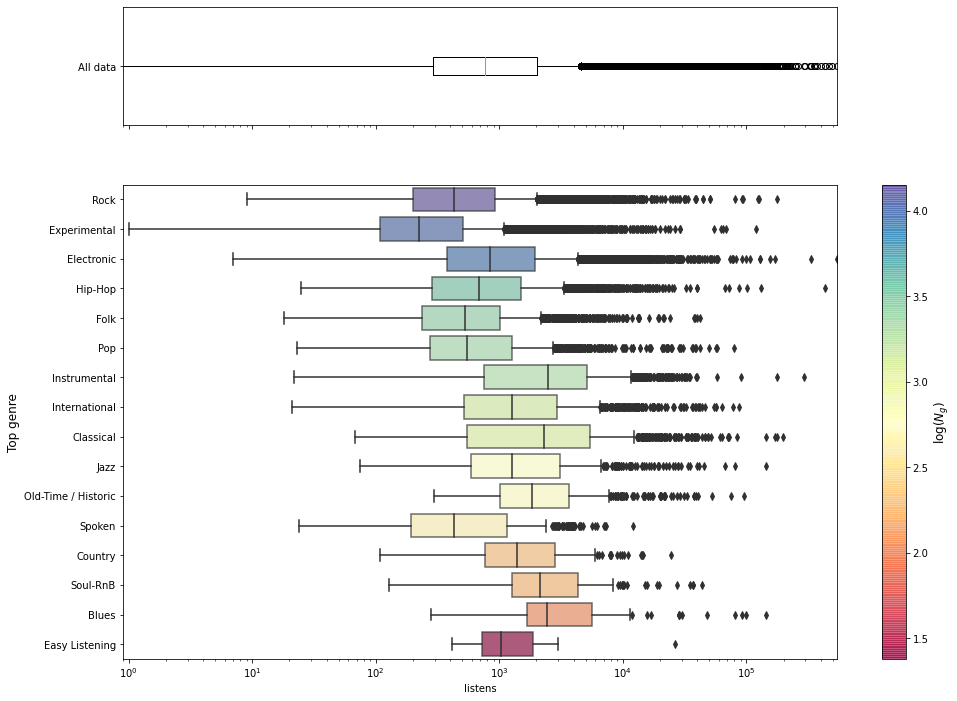

In [ ]:
import matplotlib.cm as cm
import matplotlib

# create color code reflecting the proportion of songs per genre in the dataset
sorted_genres = tracks["track"].groupby("genre_top").listens.count().sort_values(ascending=False)
cmap = cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=np.log10(sorted_genres.min())#/sorted_genres.sum()
                                   , vmax=np.log10(sorted_genres.max())#/sorted_genres.sum()
                                  )
#color_seq = np.log10(sorted_genres)/np.log10(sorted_genres.sum())
color_seq = np.log10(sorted_genres.values)#/sorted_genres.sum()

# plot the boxplot of listens for each genre
fig, ax = plt.subplots(figsize=(16,12)
                       , nrows=2 
                       , ncols=1
                       , sharex=True
                       , gridspec_kw={'height_ratios':[0.5,2]}
                      )

ax[0].boxplot(x=tracks["track"]["listens"], vert=False)
ax[0].set_xlim([0.9, np.max(tracks["track"]["listens"])])
ax[0].set_yticklabels(["All data"])
ax[0].semilogx()

sns.boxplot(x="listens"
            , y="genre_top"
            , data=tracks["track"]
            , order=sorted_genres.index
            , ax=ax[1]
            , palette=cmap(norm(color_seq))
            , boxprops=dict(alpha=.7)
           )
ax[1].semilogx()
ax[1].set_ylabel("Top genre", fontsize=12)

# add colorbar
cb = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), alpha=0.7, ax=ax[1])
cb.set_label(r"$\log(N_g)$", fontsize=12)

pos = ax[1].get_position()
pos2 = ax[0].get_position()
ax[0].set_position([pos.x0,pos2.y0,pos.width,pos2.height])

plt.show()

The above boxplots per genre, plotted on a logarithmic scale, expose the different standards of popularity for the different top genres. A logarithmic color code is added to reflect the total number of songs per genre $N_g$ in the dataset. 

It shows that if a song had $n_{l}$ listens, it could be considered very popular for one genre but not that much if it were from another genre. For example, a blues song with 1600 streams would be in the least 25% listened songs of the genre but would still have been more streamed than more than 75% of rock, experimental, hip-hop, folk or spoken music. 

#### Discretization

Finally, determining discrete categories of popularity (eg. unpopular, moderately popular, popular, extremely popular) could be useful either for building logistic regression models or for visualization purposes (see PCA). 

This can be done based on the listens percentiles. Using percentiles will create intervals of unequal lengths but has the advantage of enabling to balance categories based on selected proportions. We first propose to segregate popularity based on the 15th, 50th, and 85th percentiles, as summed up on the table below.

| Percentile | Popularity category |
| :--- | ---: |
| 0%-15% | Unpopular |
| 15%-50% | Moderately popular |
| 50%-85% | Popular |
| 85%-100% | Extremely popular |

However, as seen on the genre's exploration, these values will strongly depend on the selected set of values.

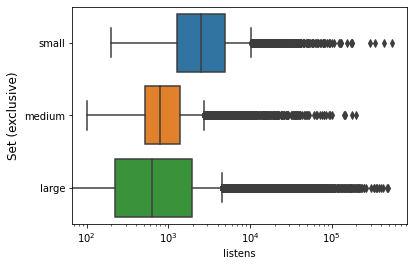

In [ ]:
df_set_listens = tracks["track"][["listens"]]
df_set_listens["set"] = tracks["set"]["subset"]

sns.boxplot(x="listens", y="set", data=df_set_listens)
plt.ylabel("Set (exclusive)", fontsize=12)
plt.semilogx()
plt.show()

In [ ]:
def popularity_percentiles(listens_list, percentiles=[15,50,85]):
    """ Discretize popularity based on given percentiles """
    listens_perc = np.percentile(listens_list, percentiles)
    return ["unpopular" if listens <= listens_perc[0]
            else "moderatly popular" if listens <= listens_perc[1]
            else "popular" if listens <= listens_perc[2]
            else "extremely popular"
            for listens in listens_list
           ]

### First regression


To quickly get more insight about our data, we now perform a linear regression, to try to find good predictors for the popularity in music.

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small_features = features[tracks['set', 'subset'] <= 'small']

Let's try a regression with the following features : the tonic (assuming it is the note that has the highest chroma cens value), the loudness (which corresponds to the mean of RMSE), the mean spectral bandwidth and the mean ZCR.

In [ ]:
regression_df = pd.DataFrame()
regression_df['listens'] = small['track']['listens']
regression_df['tonic'] = small_features['chroma_cens']['mean'].idxmax(axis=1)
regression_df['loudness'] = small_features['rmse']['mean']
regression_df['spectral_bandwith'] = small_features['spectral_bandwidth']['mean']
regression_df['ZCR'] = small_features['zcr']['mean']
regression_df.head()

listens tonic  loudness  spectral_bandwith       ZCR
track_id                                                      
2            1293    01  3.188761        1607.474365  0.085629
5            1151    09  3.251386        1512.917358  0.053114
10          50135    07  3.893810        1420.259644  0.077515
140          1299    10  2.953848        1475.625366  0.052379
141           725    11  2.576761        1192.835571  0.040267

Let's create the regression model now.
 

In [ ]:
mod = smf.ols(formula='listens ~ C(tonic)+loudness+spectral_bandwith+ZCR', data=regression_df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                listens   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.783
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           0.000379
Time:                        08:13:27   Log-Likelihood:                -86619.
No. Observations:                8000   AIC:                         1.733e+05
Df Residuals:                    7985   BIC:                         1.734e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3894.3849    597.154      6.522      0.000    2723.806    5064.963
C(tonic)[T.02]      344.1589    681.509      0.505      0.614    -991.777    1680.095
C(tonic)[T.03]     -260.9056    549.930     -0.474      0.635   -1338.913     817.102
C(tonic)[T.04]      559.6154    686.244      0.815      0.415    -785.602    1904.832
C(tonic)[T.05]     -791.4610    545.483     -1.451      0.147   -1860.751     277.829
C(tonic)[T.06]     -355.4451    639.107     -0.556      0.578   -1608.262     897.372
C(tonic)[T.07]     -758.9719    676.598     -1.122      0.262   -2085.282     567.338
C(tonic)[T.08]     -813.6974    549.598     -1.481      0.139   -1891.053     263.658
C(tonic)[T.09]     1221.2014    659.657      1.851      0.064     -71.899    2514.302
C(tonic)[T.10]     -301.0269    566.432     -0.531      0.595   -1411.382     809.328
C(tonic)[T.11]     -916.1798    715.902     -1.280      0.201   -2319.535     487.175
C(tonic)[T.12]     -785.8983    683.208     -1.150      0.250   -2125.164     553.368
loudness            181.6048     57.076      3.182      0.001      69.720     293.489
spectral_bandwith     0.7408      0.404      1.833      0.067      -0.052       1.533
ZCR               -1.505e+04   6082.520     -2.474      0.013    -2.7e+04   -3123.225
==============================================================================
Omnibus:                    18665.805   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        208709528.773
Skew:                          22.934   Prob(JB):                         0.00
Kurtosis:                     792.952   Cond. No.                     6.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The loudness and ZCR seem to be good predictors for the popularity ! (p value is less than 0.05) 

Indeed, popular musics seem to be loud (positive coefficient) while having low ZCR (negative coefficient).

That is an example of analysis that we can do to try to find correlations between musical features and popularity, that can help us answer our research question.

This is also encouraging because it goes into the direction of our hyptohesis : that popular musics are sharing features, and that we can identify some of them.

### First classification




Another first experiment that we did for the exploratory data analysis is to try another approach : classification.

We would like to predict popularity classes, as we defined them earlier.

We use the function that, as discussed before, creates four different categories : 'unpopular', 'moderatly popular', 'popular', 'extremely popular'.

In [ ]:
regression_df['Popularity'] = popularity_percentiles(regression_df['listens'])
regression_df.groupby('Popularity').count()['listens']

Popularity
extremely popular    1200
moderatly popular    2797
popular              2800
unpopular            1203
Name: listens, dtype: int64

We will try to perform LDA to cluster diffent levels of popularity in music.

We start by doing this with the feature 'MFCC', to see what kind of insight about popularity this feature can give us.

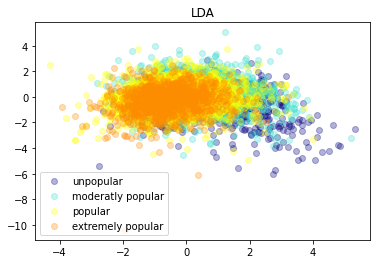

In [ ]:
small_loc_classification = tracks['set', 'subset'] <= 'small'
X = features.loc[small_loc_classification, 'mfcc']
y = regression_df['Popularity']

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure()
colors = ['navy', 'turquoise', 'yellow', 'darkorange']

for color, target_name in zip(colors, ['unpopular', 'moderatly popular', 'popular', 'extremely popular']):
    plt.scatter(X_r2[y == target_name, 0], X_r2[y == target_name, 1], alpha=.3, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')

plt.show()

The results are looking a bit messy and do not really give us a lot of information, let's try to only look at the extremes popularity types.

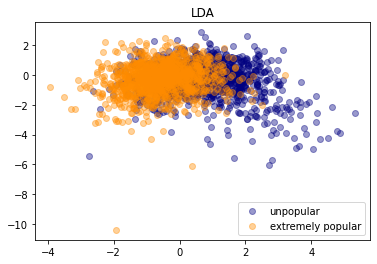

In [ ]:
plt.figure()
colors = ['navy', 'darkorange']

for color, target_name in zip(colors, ['unpopular', 'extremely popular']):
    plt.scatter(X_r2[y == target_name, 0], X_r2[y == target_name, 1], alpha=.4, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')

plt.show()

Here, on the other hand, we see a blurry distinction between unpopular and extremely popular music. The MFCC feature seems to also detain some information about popularity. For example, a music that would fall in the right side of the plane would be less likely to be popular.

### What's next

To answer our research question, we need to perform a more complex analysis of our dataset. 

We first want to analyze on the largest dataset the impact of the different features we have on popularity. We will for that use the same process as we did above : linear regressions and LDA, with the largest range of features that we have at our disposition. That will allow us to have an in depth understanding of the impact of each feature on the popularity of a music. 

Then, will follow a more fine-grained analysis of what makes music popular within genres. We will for that apply the same methods as earlier, but eight different times on the eight different genres of the fma-small dataset. This will allow us to be more precise on which features are important for a music to be popular, with no genre bias.

### Expectations


If we look into the existing litterature, we see that we might expect music's pitch ([Jakubowski et al., 2017](#jakubowski); [Yang et. al, 2017](#yang); [Lee & Lee, 2018](#lee)), tempo ([Ni et al., 2011](#ni); [Jakubowski et al., 2017](#jakubowski); [Léveillé Gauvin, 2017](#gauvin)) and intrinsic loudness ([Ni et al., 2011](#ni); [Serra et al., 2012](#serra); [Gauvin, 2017](#gauvin); [Lee & Lee, 2018](#lee))to be features to discriminate hit songs from non-hits. 

For the between-genre analysis, we expect the feature that we identify to be only very general features for popular music, because all the genres are mixed, thus having a very diverse corpora, making it difficult to identify any precise feature.

Then, with the precise study of the eight genres, we would expect to have better result, more significant. Indeed, the analysis is within genre, so we are more likely to find genre-specific features for popular music, that would have been hidden with the between-genre analysis.


### Evaluation of Outcomes

To evaluate the results of the regression, we can look at the p-value of every coefficient for every feature. If the p-value is less than 0.05, that means that we reject at 95% the null hypothesis, which is that there is no linear relationship between the independent variable (the feature) and the dependent variable (the popularity). Only the features with this statistically significant relationship with popularity will be considered to have a role in popularity.

Then, to evaluate the Linear Discriminant Analysis, we will use the Leave-One-Out cross-validation technique, and look for features that produce the best scores.